In [1]:
!pip install flask-ngrok
!pip install flask-bootstrap
!pip install pyngrok==4.1.1
!ngrok authtoken '1iBePQJDOtDUWe4tSGVLfinfPpE_5zsuX8eudpCVCv21A46yc'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 456 kB 7.4 MB/s 
  Created wheel for flask-bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=d5a1dbab55c0202217225ae76fb73465d5967d39b820e4a803ef2a4b1163c1e8
  Stored in directory: /root/.cache/pip/wheels/f2/a3/85/fe8b65a65a447c9906e3b7edb7d9e6c74dfa9c8425c3dd3007
  Created wheel for visitor: filename=visitor-0.1.3-py3-none-any.whl size=3943 sha256=b5c33af4f5f6ee76bea3079c6b4a574c4c38da01d4c0af9319f89309ab616e30
  Stored in directory: /root/.cache/pip/wheels/d3/40/52/5dae7760434a82caf8b8f88323029188b2d4ea3ac1235e550a
Successfully built flask-bootstrap visitor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.wh

In [2]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.9.2
The following GPU devices are available: /device:GPU:0


In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imsave('results.jpg',image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [4]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

In [5]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  data_to_confidence = {}
  for i in range(len(result['detection_class_entities'])):
    if result['detection_scores'][i]*100 >= 10:
      data_to_confidence[result['detection_class_entities'][i]] = result['detection_scores'][i]*100
  final_data = []
  for elem in list(data_to_confidence.keys()):
    obj = {
        'Object' : elem.decode('ASCII'),
        'Confidence' : data_to_confidence[elem]
    }
    final_data.append(obj)
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)
  return final_data

In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [7]:
import os
os.mkdir('images')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3eae-34-141-165-19.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 17:53:15] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 17:53:15] "GET /favicon.ico HTTP/1.1" 404 -


Found 100 objects.
Inference time:  45.37144327163696


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 17:54:09] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  3.0717294216156006


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:00:06] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2421200275421143


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:00:19] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2409634590148926


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:05:20] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2036778926849365


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:06:57] "POST /objectDetect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:08:19] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1985628604888916
Found 100 objects.
Inference time:  2.9250223636627197


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:11:41] "POST /objectDetect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:12:29] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2157139778137207
Found 100 objects.
Inference time:  1.3057751655578613


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:13:09] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1794698238372803


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:13:25] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2206590175628662


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:14:09] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2042136192321777


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:14:25] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2007160186767578


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:15:23] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1935491561889648


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:15:47] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1881070137023926


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:16:07] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.203557014465332


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:21:17] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1767017841339111


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:21:39] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1981158256530762


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:22:07] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.18098783493042


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:22:56] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.2285704612731934


INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:23:21] "POST /objectDetect HTTP/1.1" 200 -
<ipython-input-3-e3da56a5eaa2>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 15))
INFO:werkzeug:127.0.0.1 - - [01/Jan/2023 18:23:41] "POST /objectDetect HTTP/1.1" 200 -


Found 100 objects.
Inference time:  1.1957972049713135


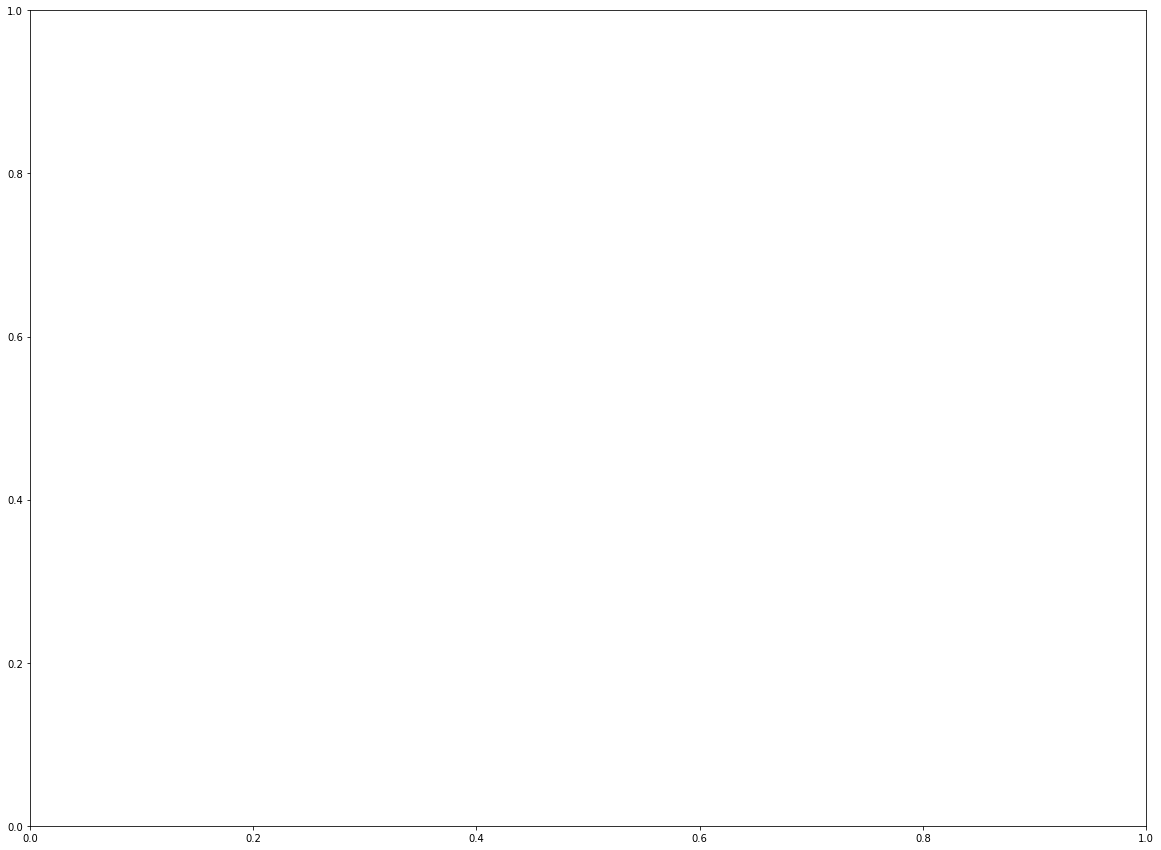

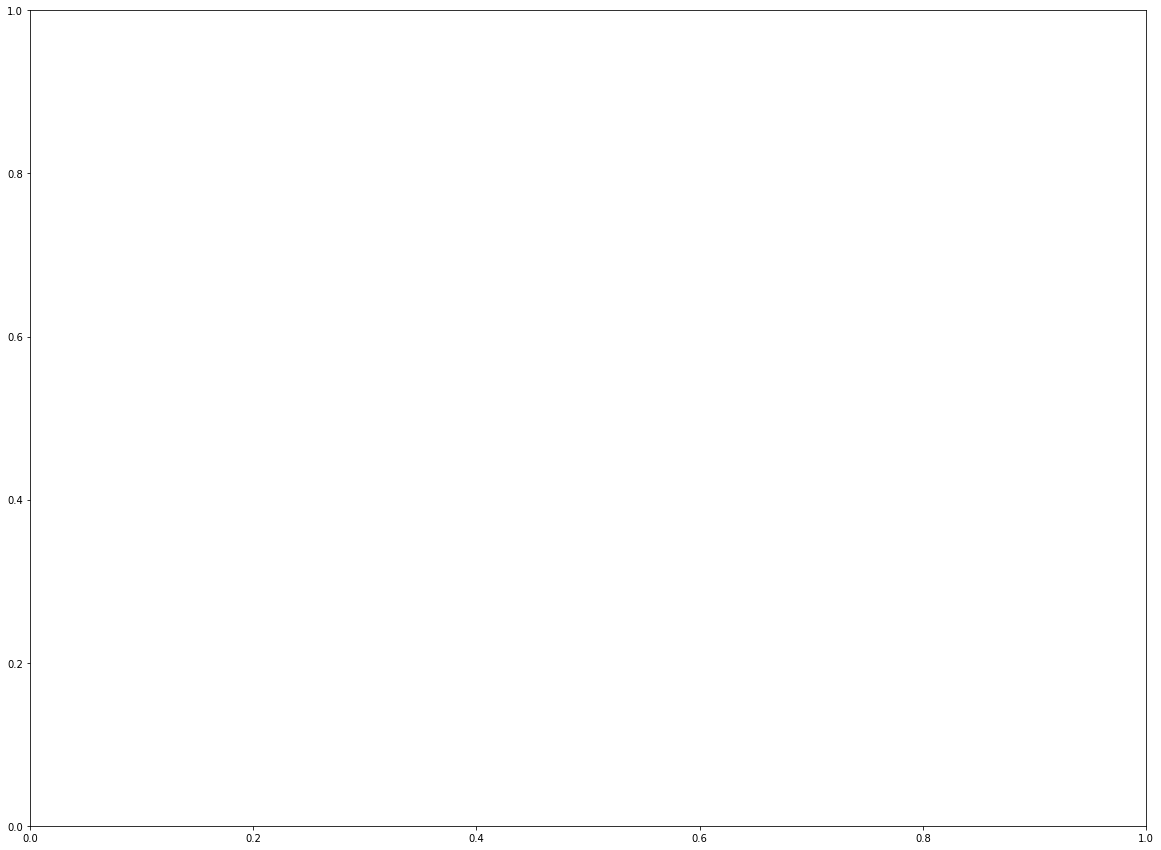

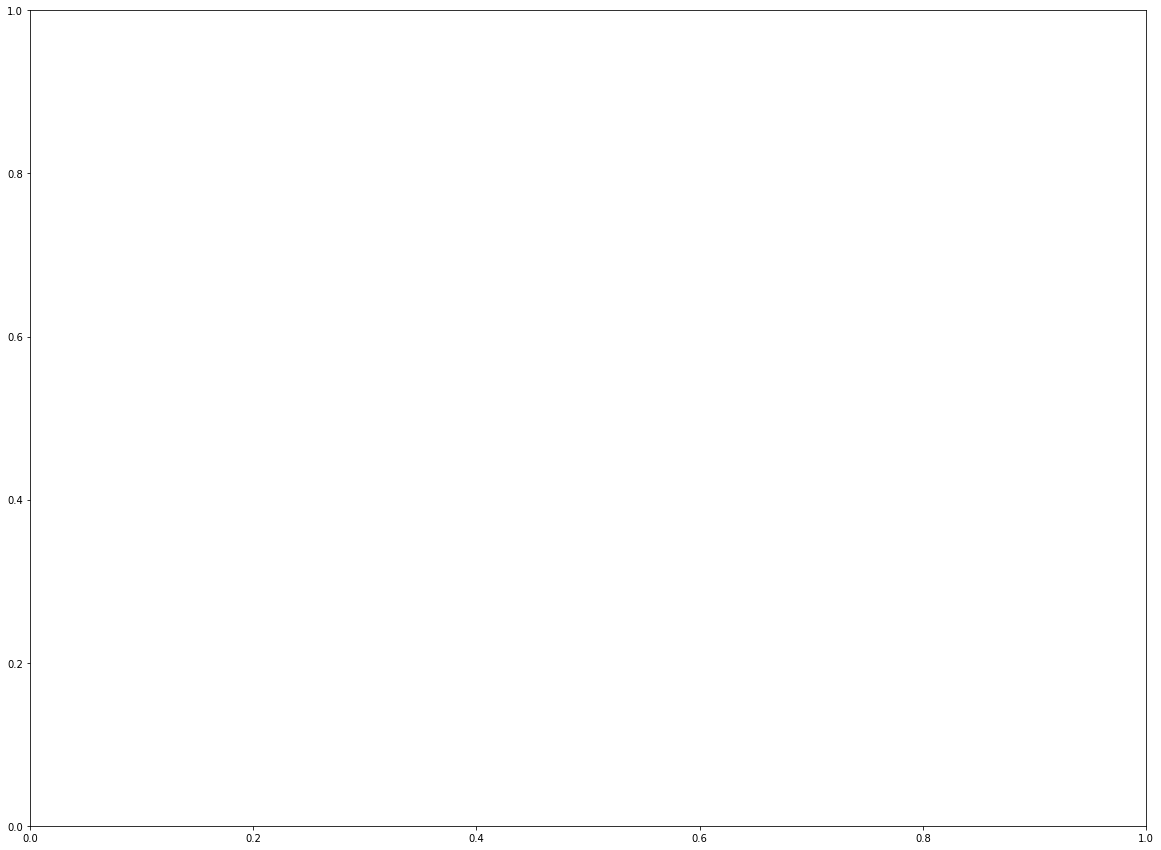

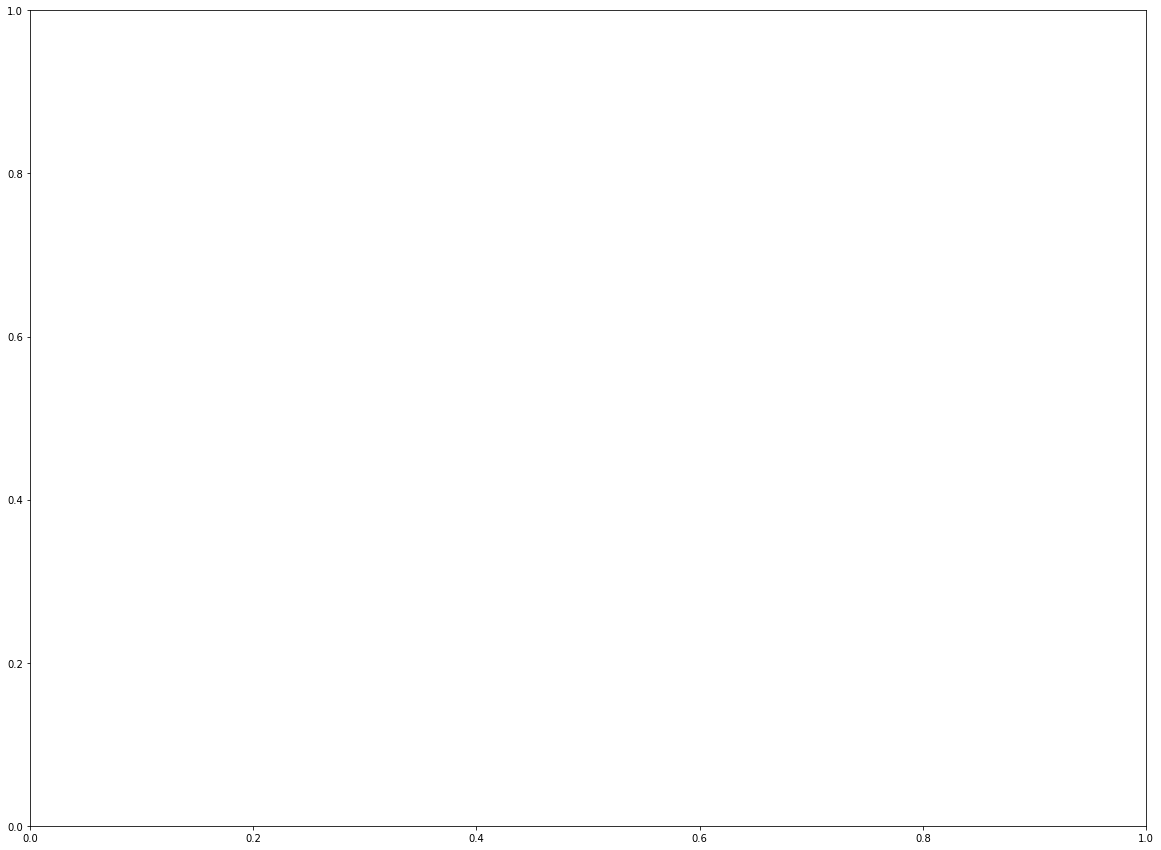

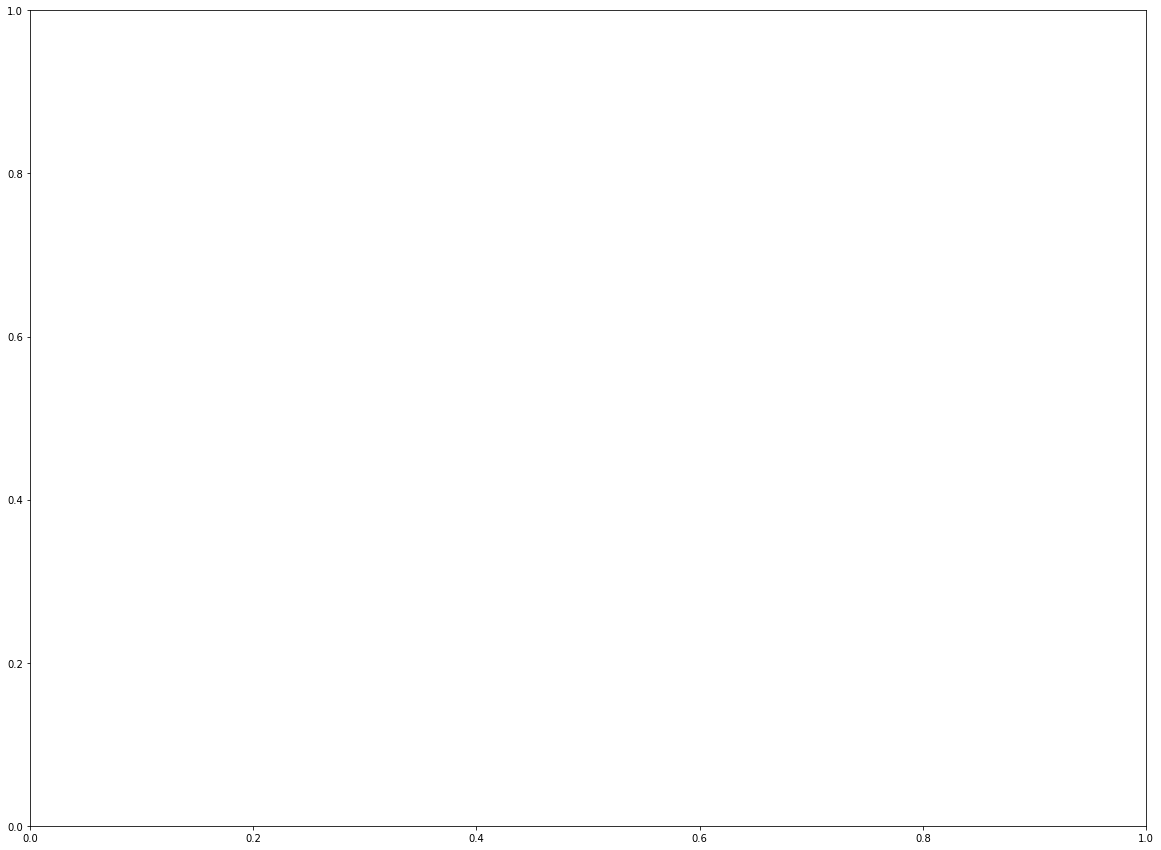

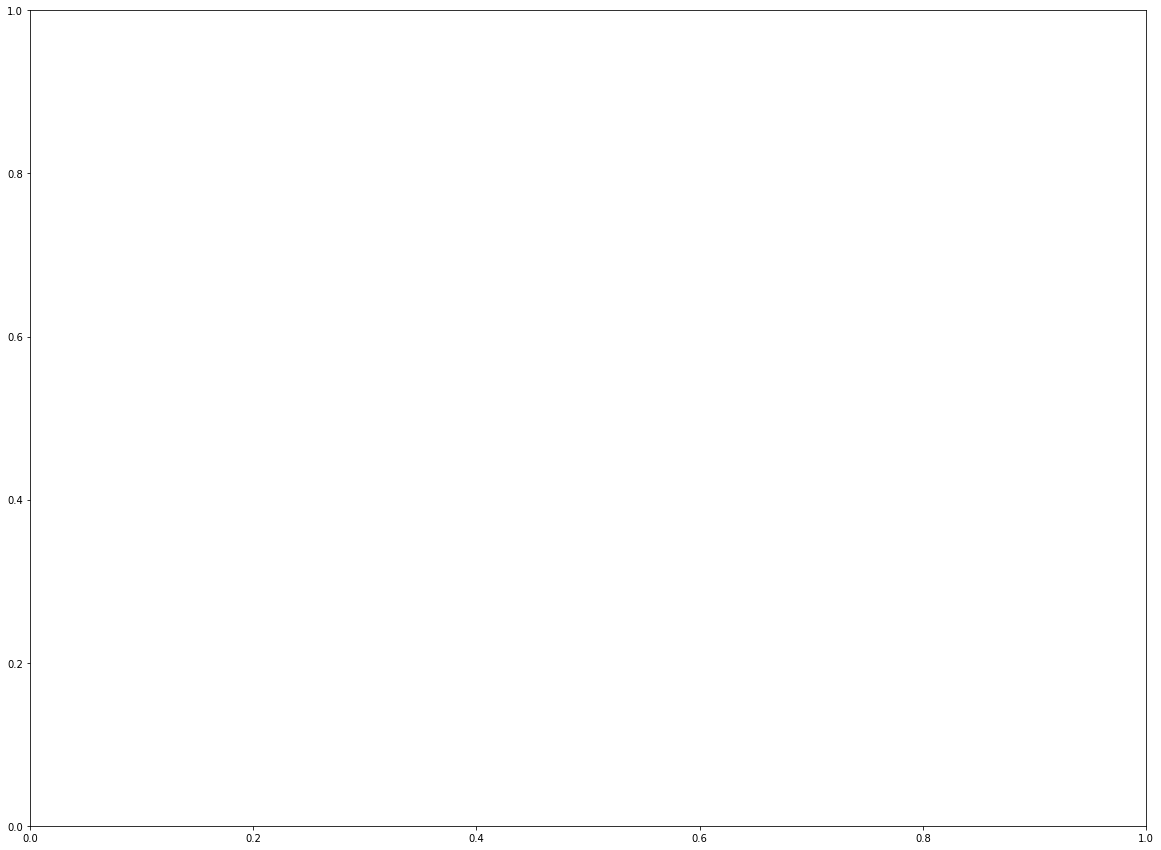

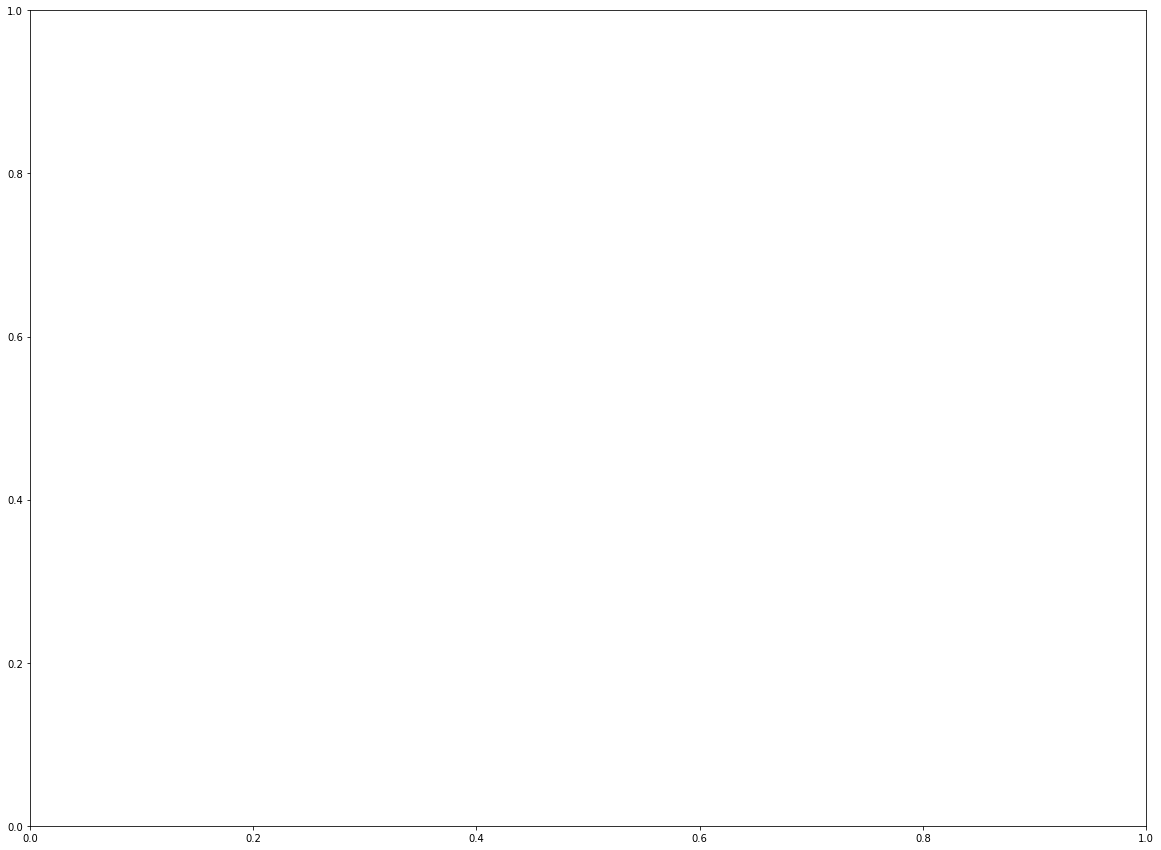

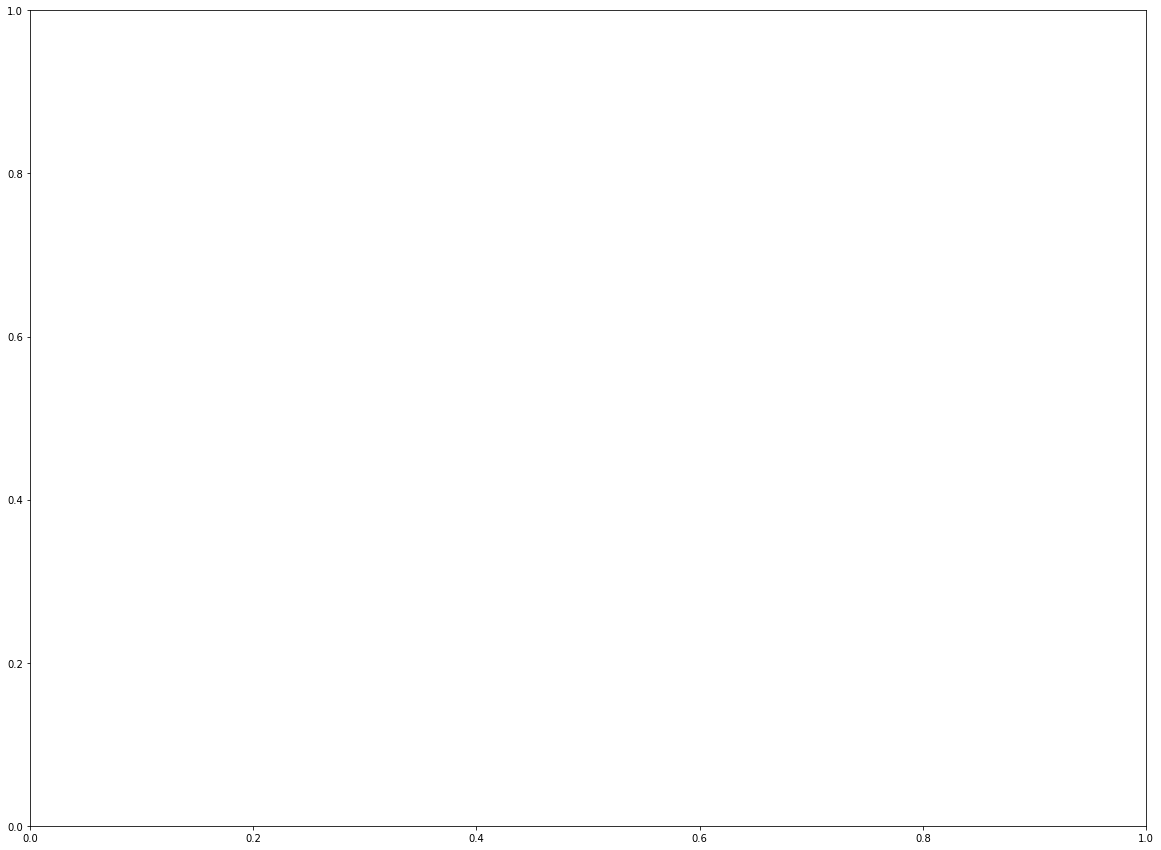

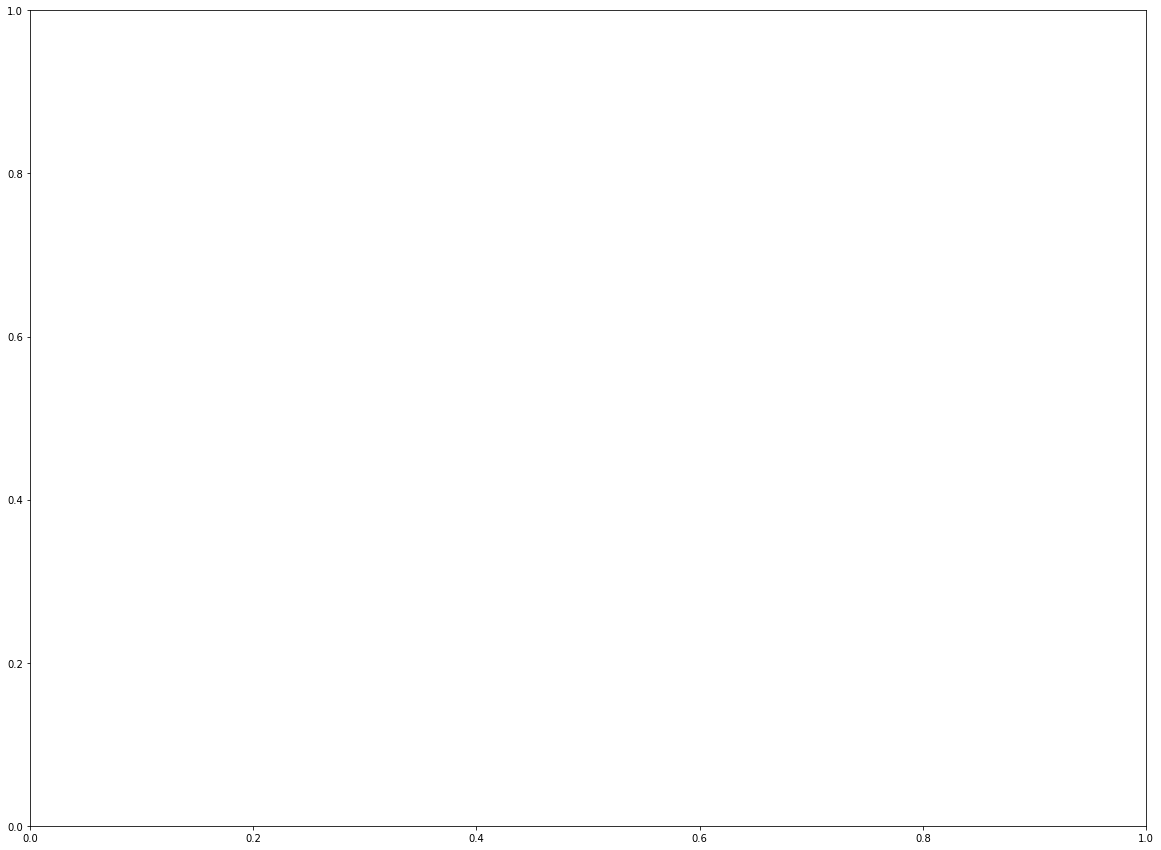

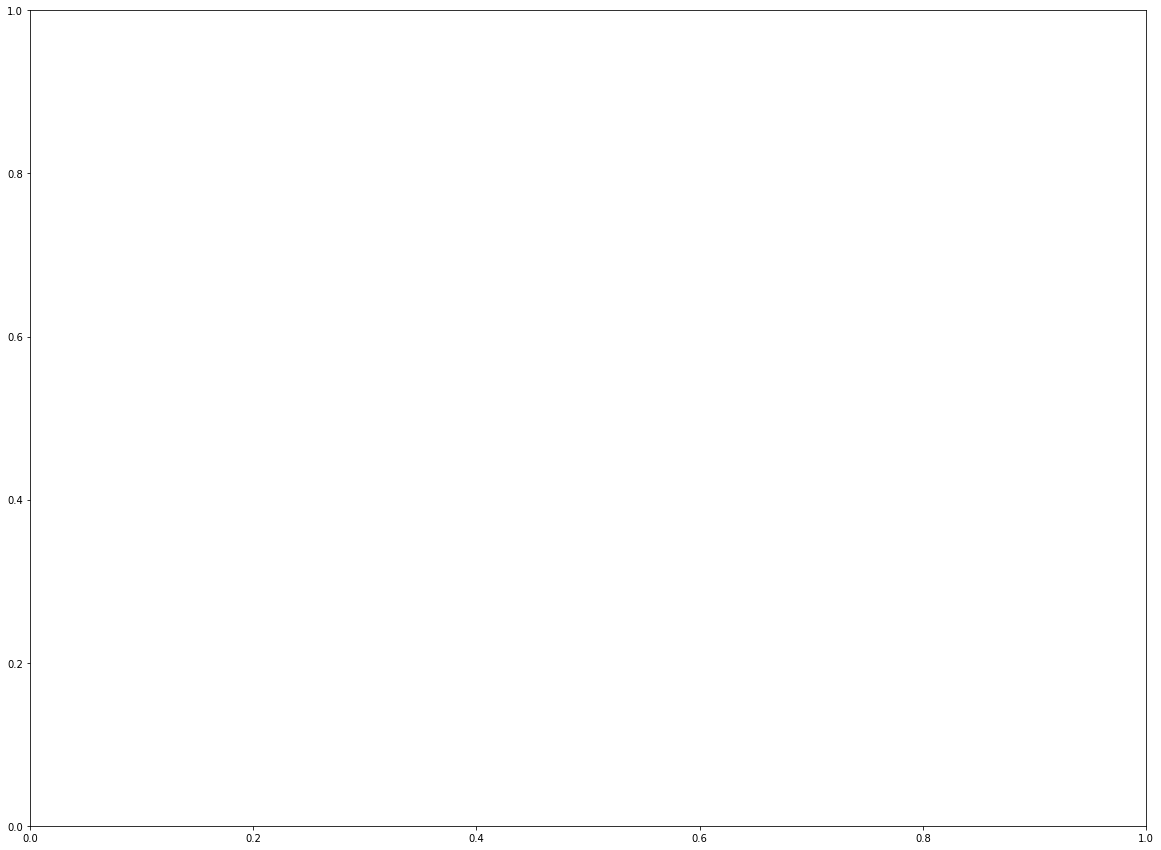

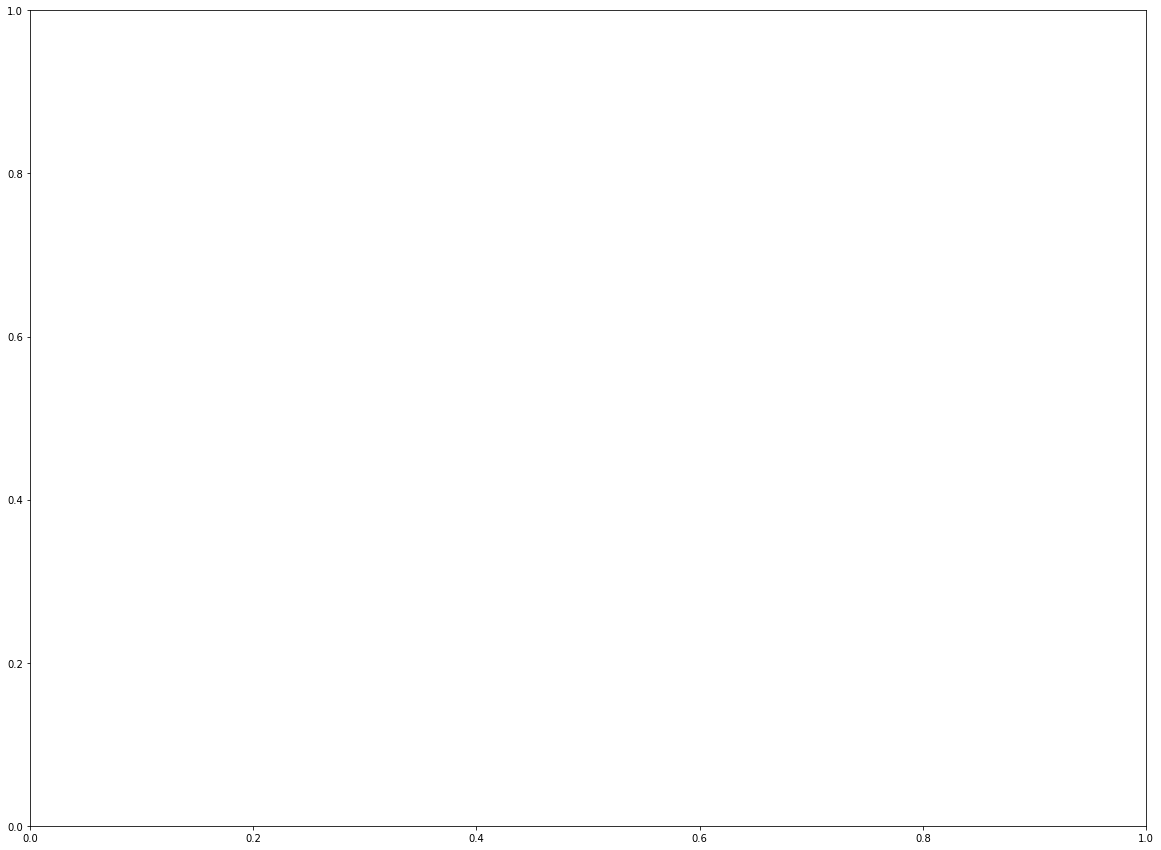

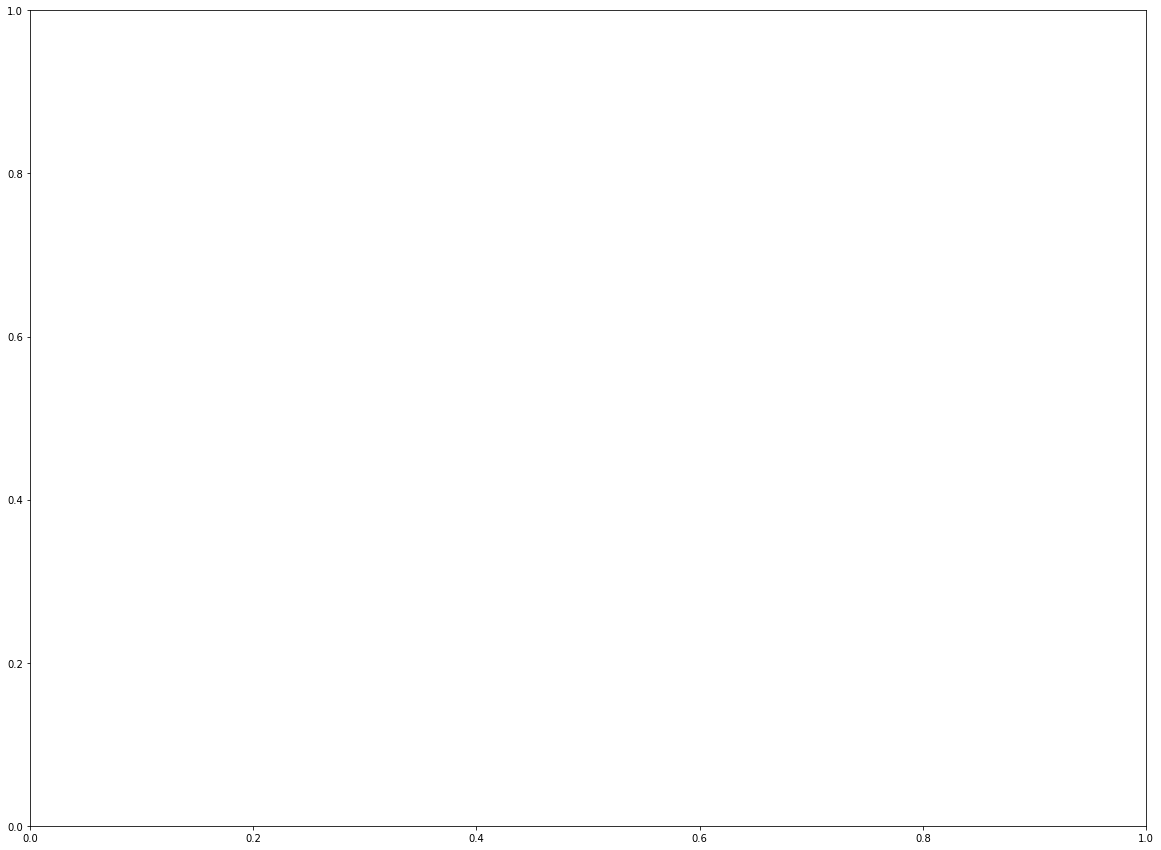

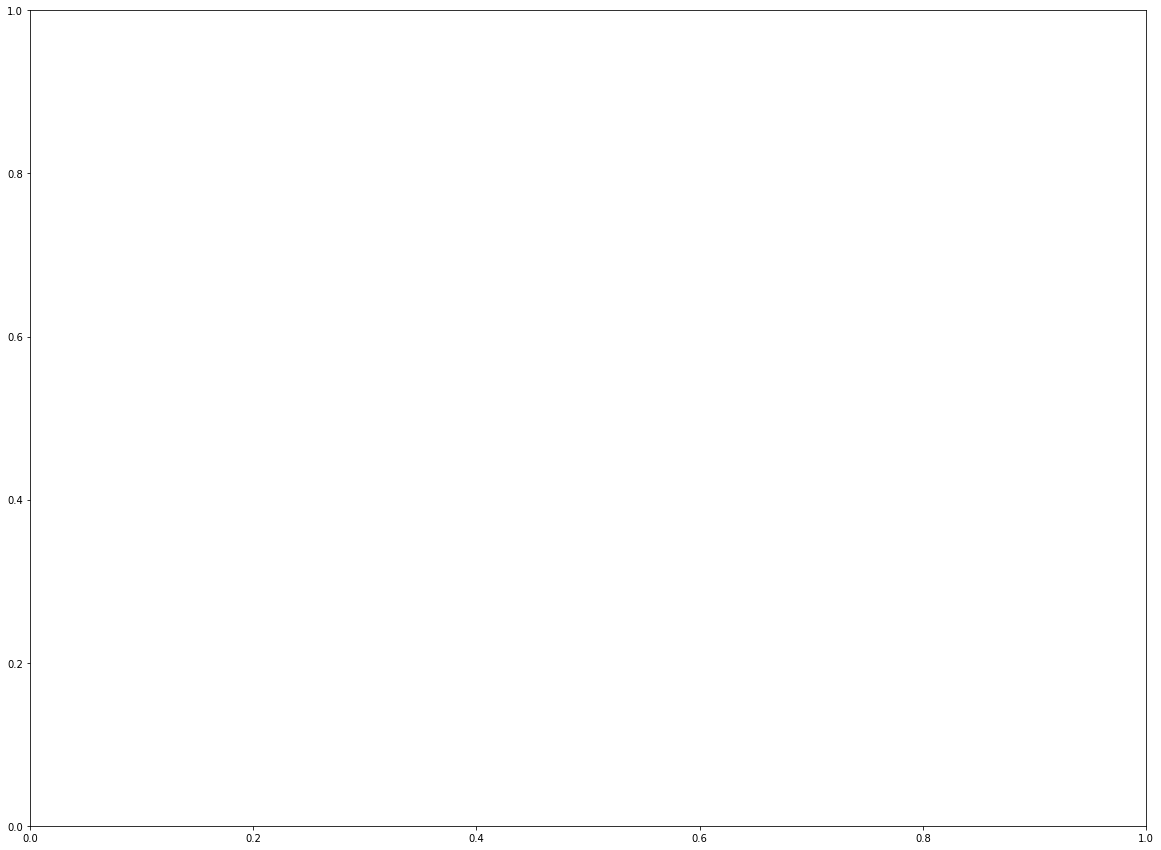

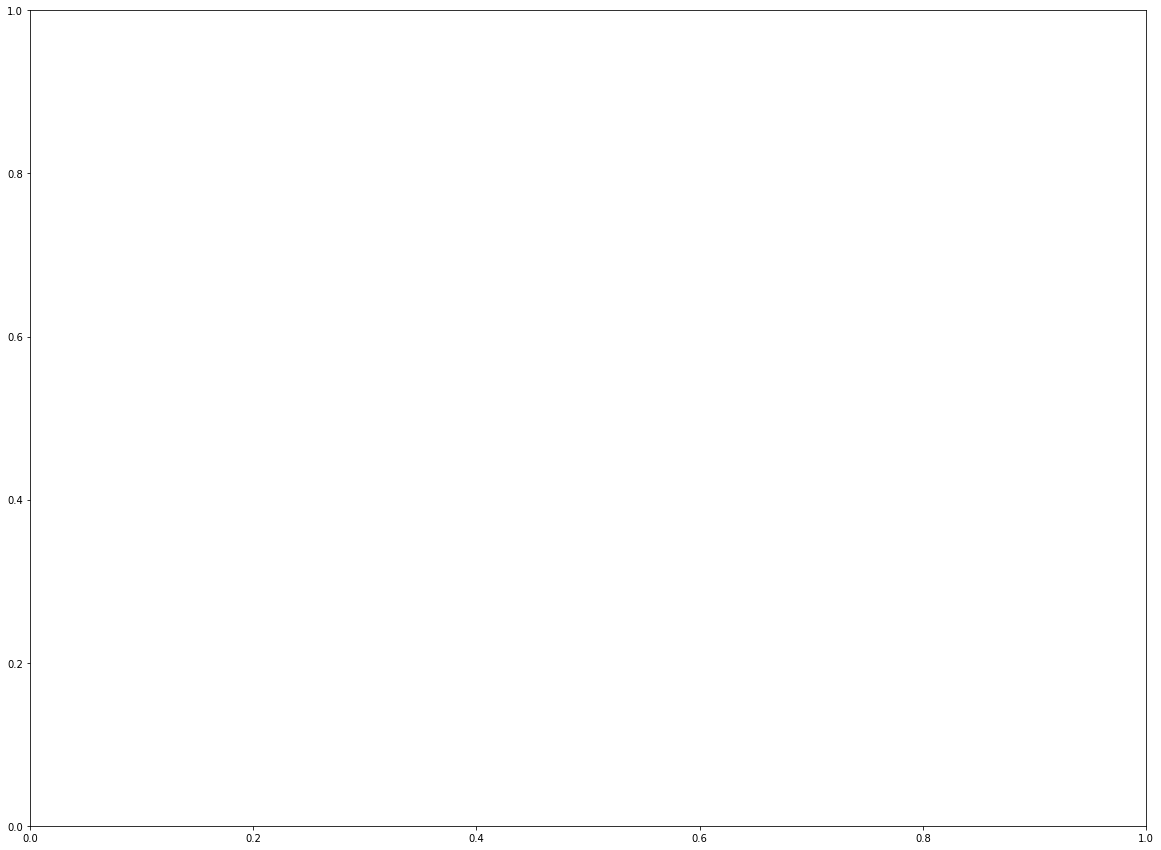

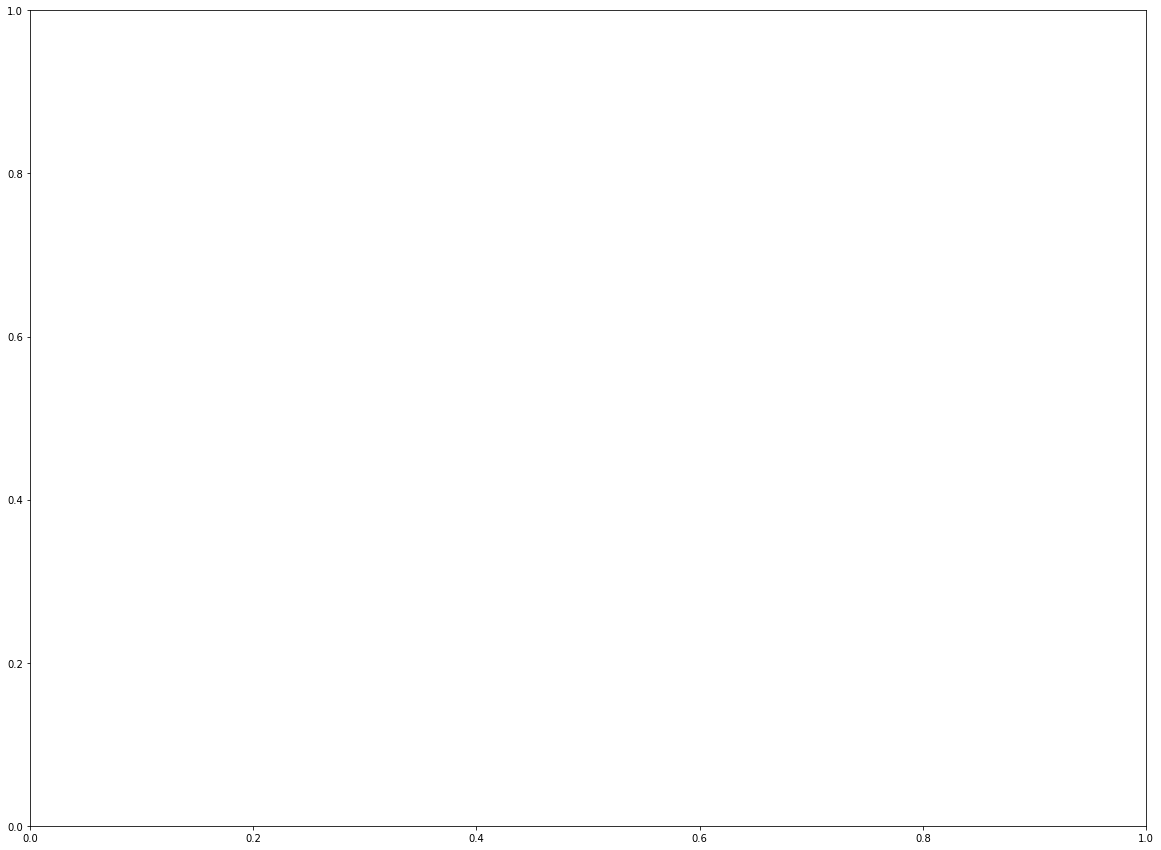

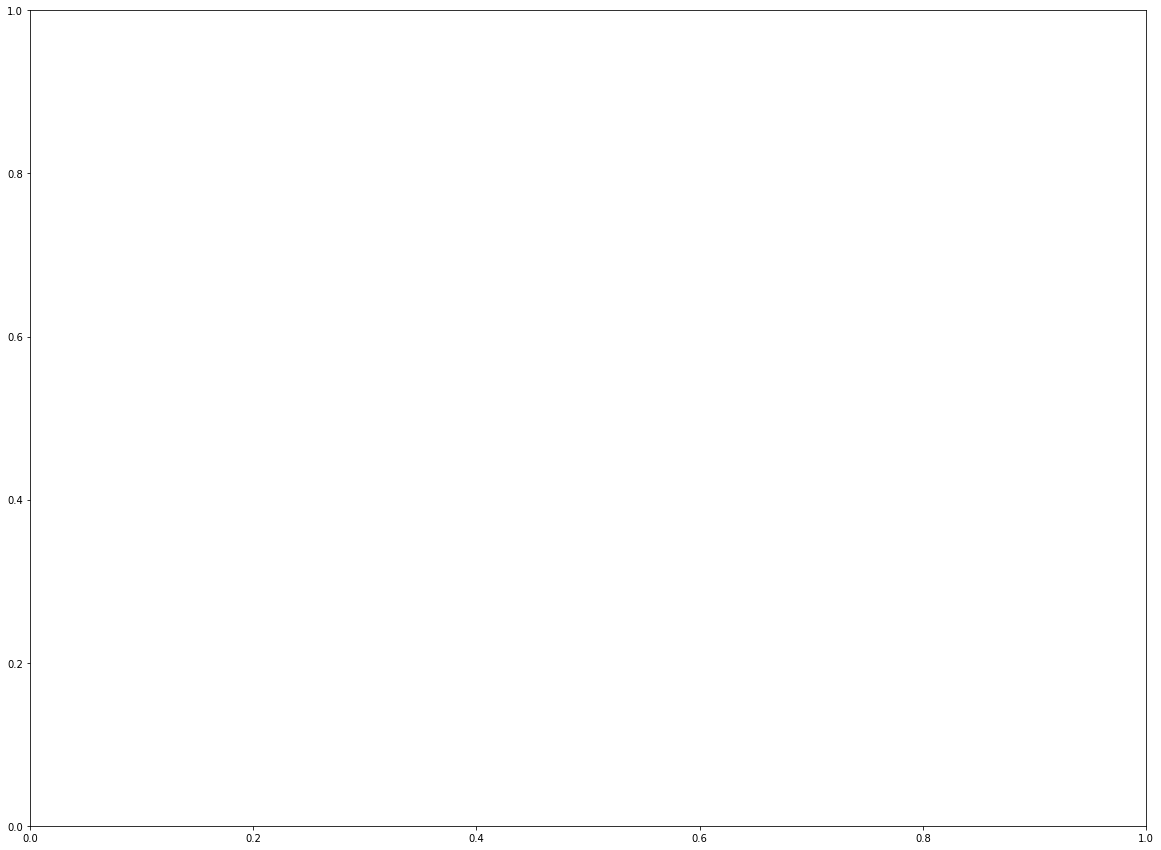

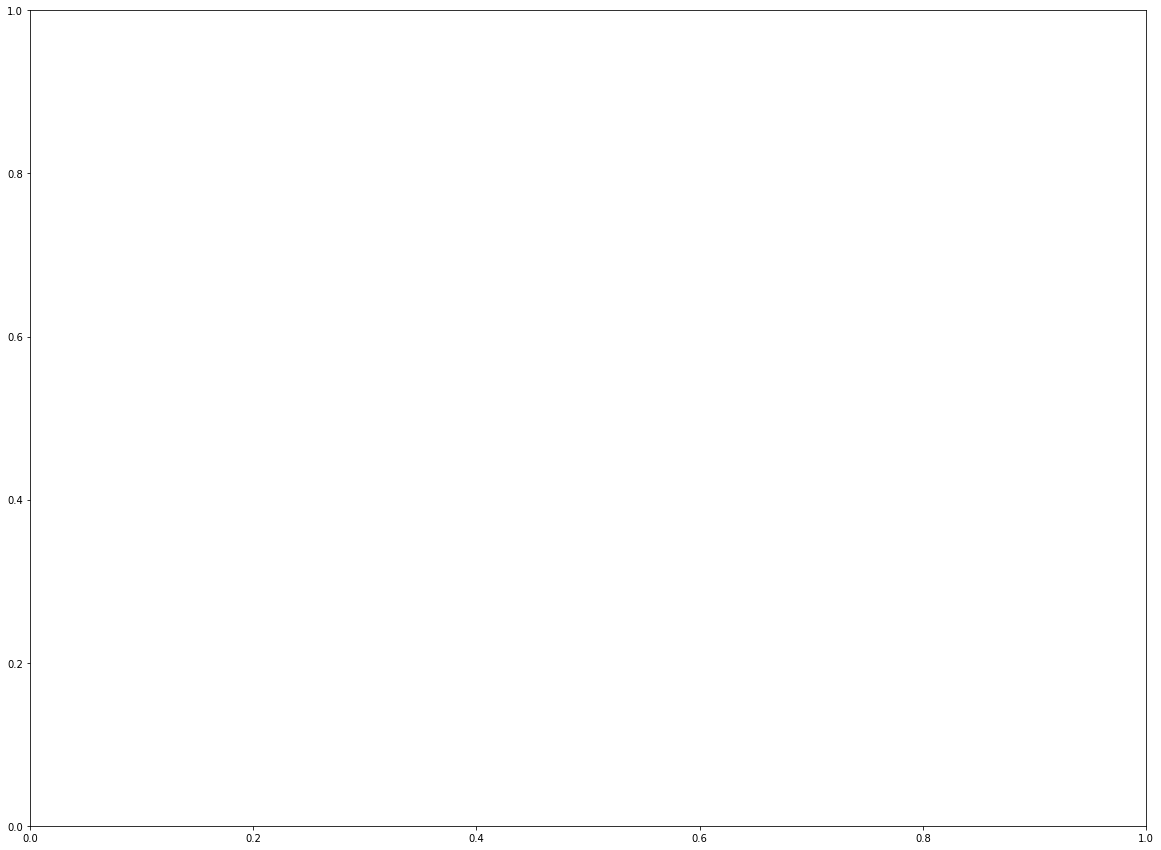

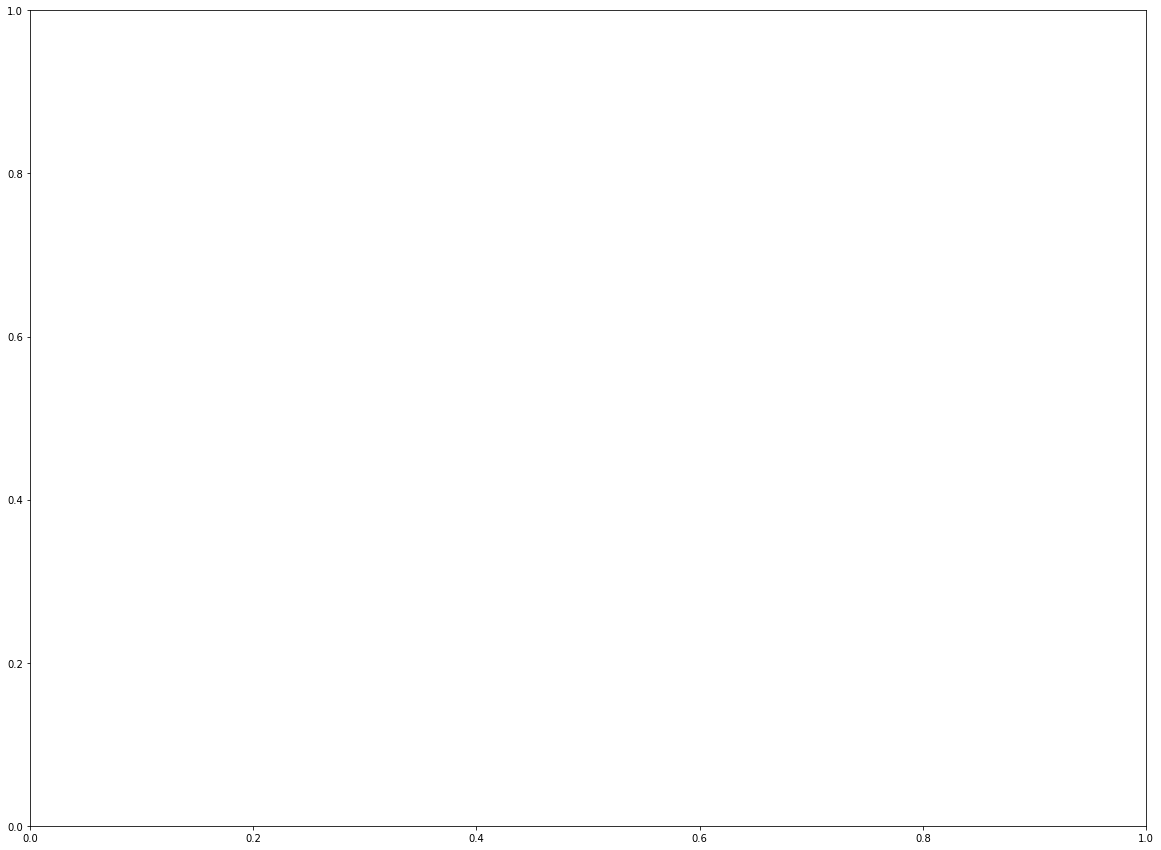

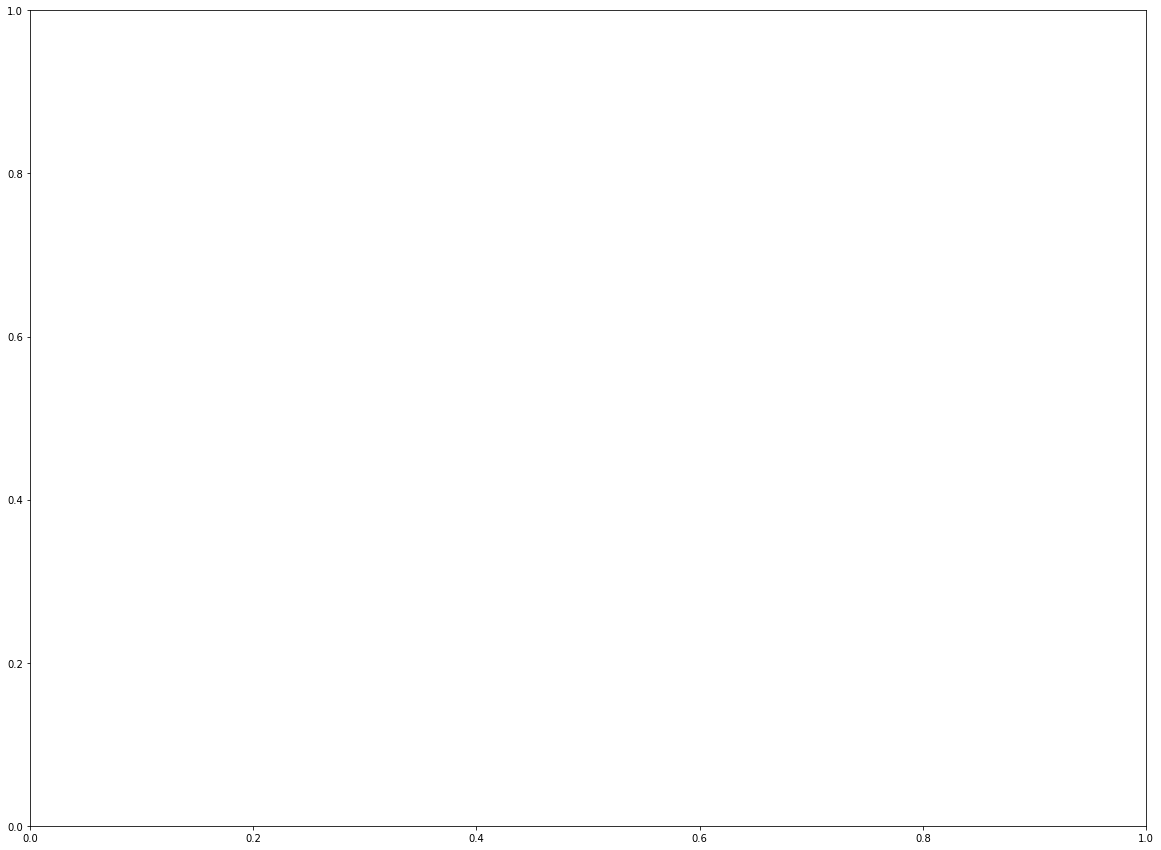

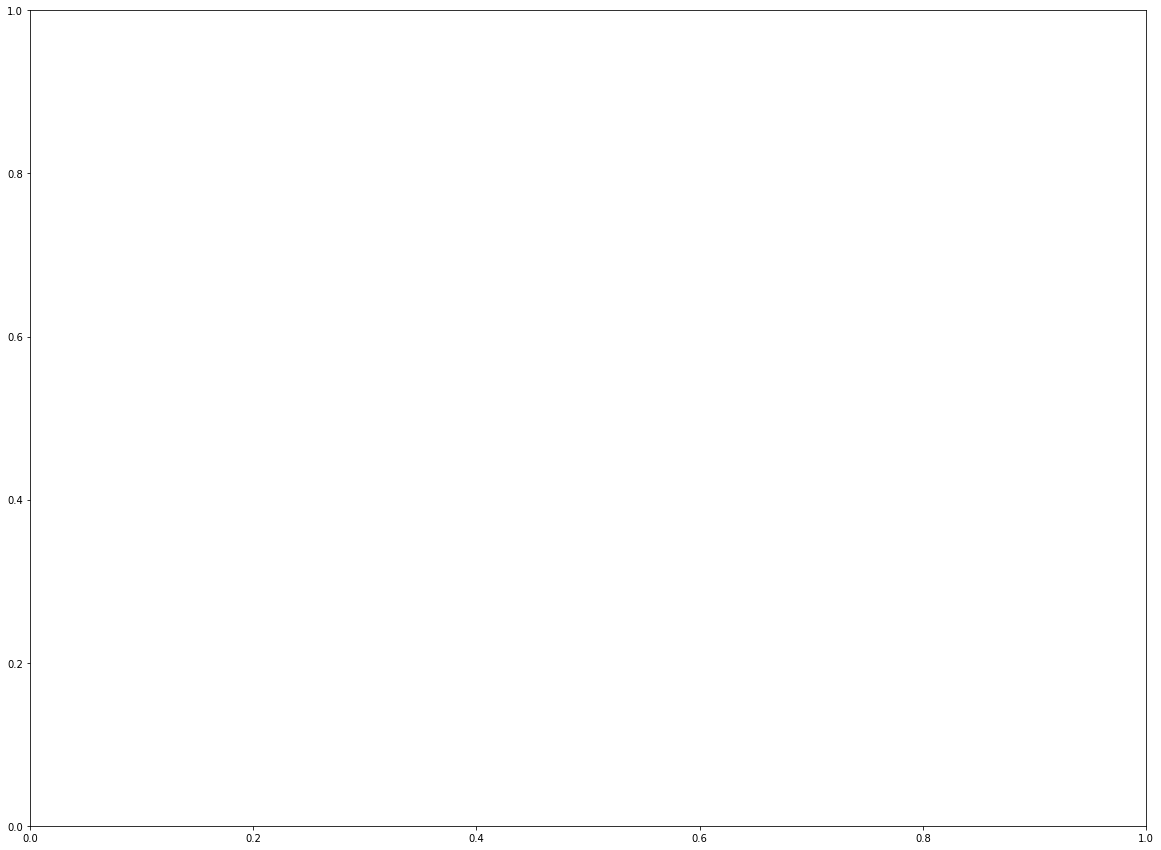

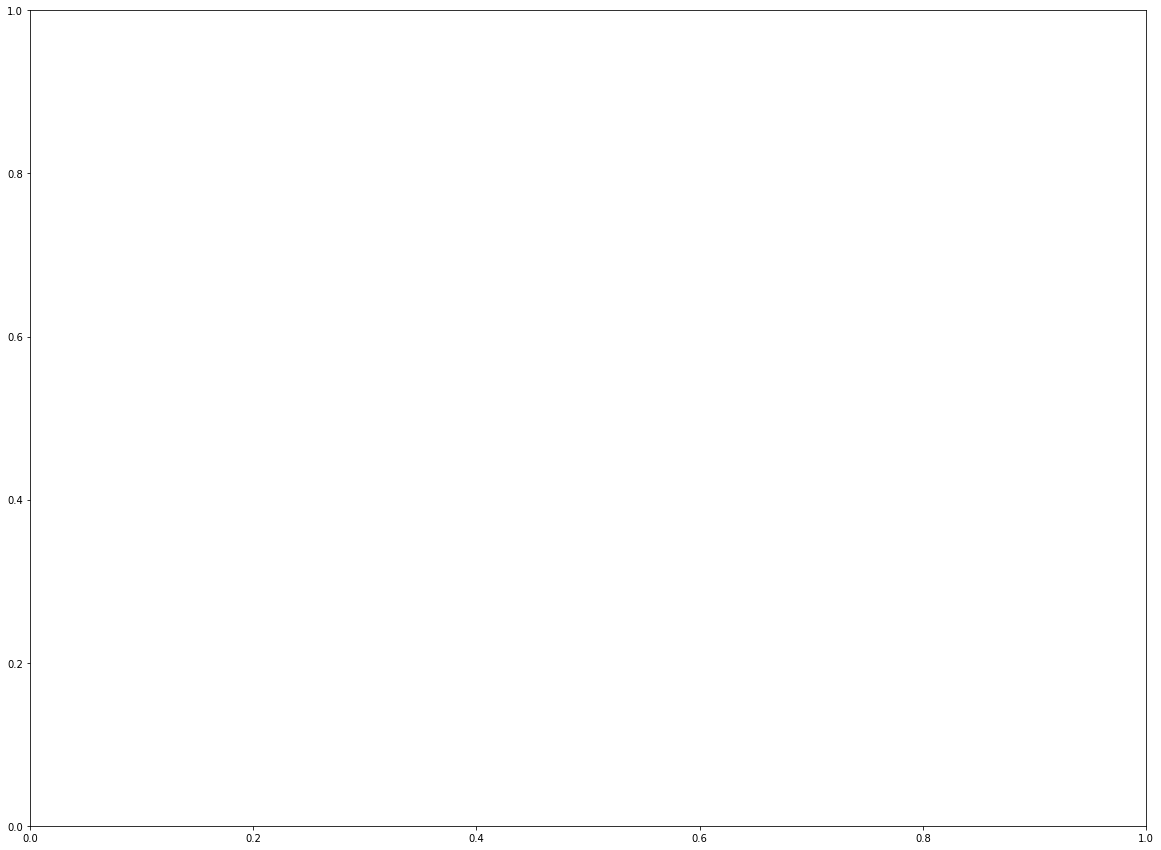

In [16]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template , request , jsonify
import os
import base64


app = Flask(__name__, template_folder='/content/static')
app.config['UPLOAD_FOLDER'] = 'images'
run_with_ngrok(app)

@app.route('/',methods = ['GET'])
def home():
  return jsonify({
      "message" : "This API is working properly"
  })

@app.route('/objectDetect',methods = ['POST'])
def find_objects():

  file = request.files['image']
  file.save(os.path.join(app.config['UPLOAD_FOLDER'], 'uploadedImage.jpg'))
  final_data = run_detector(detector, 'images/uploadedImage.jpg')
  with open("results.jpg", "rb") as img_file:
    base_64_bytes = base64.b64encode(img_file.read())
  mystring = base_64_bytes.decode('utf-8')
  
  return jsonify({
      "data" : final_data,
      "image" : mystring

  })
if __name__ == '__main__':
   app.run()